In [6]:
import os
os.chdir('/home/jupyter-nafisha/chexAgent-Normal-Abnormal/main')

In [4]:
import os
import pandas as pd

img_dir = '/home/common/data_v3'
train_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/val.csv'
df = pd.read_csv(train_csv)

In [5]:
len(df)

7162

In [2]:
import torch

def encode_view(orientation):
    # 0: PA, 1: AP, 2: Lateral
    if orientation == "lateral":
        return 2
    if orientation == "PA":
        return 0
    return 1

def encode_sex(sex):
    return 0 if sex == "M" else 1

In [3]:
import torch
from PIL import Image
from transformers import AutoModel, AutoProcessor, AutoConfig

In [20]:
MODEL_NAME = "StanfordAIMI/XraySigLIP__vit-l-16-siglip-384__webli"

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
dtype = torch.float32 

In [21]:
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)

# Load processor (VERY IMPORTANT)
processor = AutoProcessor.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)

# Load vision model ONLY
vision_full = AutoModel.from_pretrained(
    MODEL_NAME,
    config=config,
    trust_remote_code=True
).to(device, dtype)

vision_encoder = vision_full.vision_model
del vision_full

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
from dataset import CXRMulitmodalDataset
from model import CheXagentSigLIPBinary

In [14]:
from torch.utils.data import DataLoader

test_dataset = CXRMulitmodalDataset(train_csv, img_dir, transform=None)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Ground-truth labels (Normal=0, Abnormal=1)
true_labels = test_dataset.df["label"].map({"Normal": 0, "Abnormal": 1}).tolist()
image_names = test_dataset.df["image_id"].tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

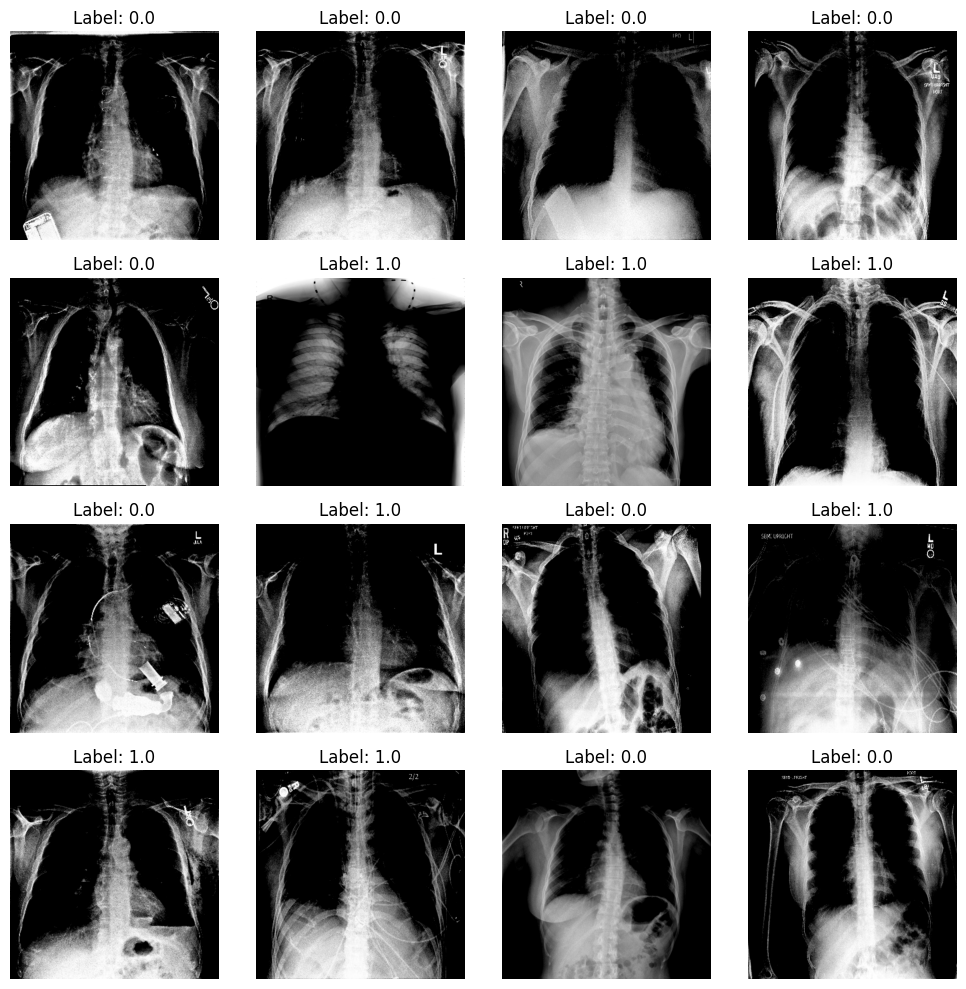

In [15]:
import matplotlib.pyplot as plt
import torch

# Get one batch
for images, view, sex, label in test_loader:
    break  # only take the first batch

# Plot 16 images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    img = images[i].permute(1, 2, 0)  # C,H,W → H,W,C
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {label[i].item()}")

plt.tight_layout()
plt.show()

In [17]:
model = CheXagentSigLIPBinary(vision_encoder= vision_encoder)
model.to(device)

CheXagentSigLIPBinary(
  (vision_encoder): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(1024, 1024)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-23): 24 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_fe

In [18]:
predictions = []
with torch.no_grad():
    for images, view, sex, label in test_loader:  
        images = images.to(device)
        view = view.to(device)
        sex = sex.to(device)
        label = label.to(device)

        logits = model(images, view, sex)             # shape: (B, 1)
        probs = torch.sigmoid(logits).squeeze(1)  # shape: (B,)
        # probs = torch.sigmoid(logits)

        preds = (probs >= 0.5).long()      # thresholding for binary prediction

        # predictions.extend(preds.cpu().numpy())
        # print(label, preds)
        predictions.extend(preds.cpu().numpy().tolist())
        break

In [19]:
predictions

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# prediction

In [16]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch import nn, optim
from dataset import CXRMulitmodalDataset
from model import CheXagentSigLIPBinary
from transformers import AutoModel, AutoProcessor, AutoConfig

In [17]:
MODEL_NAME = "StanfordAIMI/XraySigLIP__vit-l-16-siglip-384__webli"
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'cpu'
dtype = torch.float32

In [18]:
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)
vision_full = AutoModel.from_pretrained(
    MODEL_NAME,
    config=config,
    trust_remote_code=True
).to(device, dtype)
vision_encoder = vision_full.vision_model
del vision_full

In [31]:
checkpoint_path= '/home/jupyter-nafisha/chexAgent-Normal-Abnormal/main/best_model.pth'
model = CheXagentSigLIPBinary(vision_encoder= vision_encoder)
model.to(device)
ckpt = torch.load(checkpoint_path, map_location="cpu", weights_only= False)
model.load_state_dict(ckpt)
model.eval()

CheXagentSigLIPBinary(
  (vision_encoder): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(1024, 1024)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-23): 24 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_fe

In [32]:
# Total parameters
total_params = sum(p.numel() for p in model.parameters())

# Trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 317,008,417
Trainable parameters: 317,008,417


In [27]:
test_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/PADCHEST_selected_with_reports.csv'
img_dir = '/home/jupyter-nafisha/X-ray-covariates/padchest_normalized'

In [28]:
test_dataset = CXRMulitmodalDataset(test_csv, img_dir, transform=None)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [29]:
true_labels = test_dataset.df["label"].map({"Normal": 0, "Abnormal": 1}).tolist()
image_names = test_dataset.df["image_id"].tolist()

In [ ]:
predictions = []

with torch.no_grad():
    for images, view, sex, label in test_loader:  
        images = images.to(device)
        view = view.to(device)
        sex = sex.to(device)
        label = label.to(device)

        logits = model(images, view, sex)             # shape: (B, 1)
        probs = torch.sigmoid(logits).squeeze(1)      # shape: (B,)

        preds = (probs >= 0.5).long()      # thresholding for binary prediction

        predictions.extend(preds.cpu().numpy().tolist())

In [ ]:
acc = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
cm = confusion_matrix(true_labels, predictions)

tn, fp, fn, tp = cm.ravel()
# Specificity
specificity = tn / (tn + fp)

In [4]:
26432 + 6378

32810

In [5]:
pwd

'/home/jupyter-nafisha/chexAgent-Normal-Abnormal'

In [6]:
import pandas as pd
csv_path = '/home/jupyter-nafisha/X-ray-covariates/CSVs/combined.csv'

In [8]:
data = pd.read_csv(csv_path)

In [15]:
len(data)

47746

In [11]:
import numpy as np
len(np.unique(data['image_id']))

47746

In [13]:
img_dir = '/home/common/data_v3'
for _, row in data.iterrows():
    path = os.path.join(img_dir, row['image_id'])
    if not os.path.exists(path):
        print(path)

In [16]:
from collections import Counter

cnt = Counter(data['image_id'])
duplicates = [k for k, v in cnt.items() if v > 1]

print("Images appearing multiple times:", len(duplicates))


Images appearing multiple times: 0


In [17]:
import os

def count_images(root):
    cnt = 0
    for _, _, files in os.walk(root):
        cnt += len([f for f in files if f.lower().endswith(('.jpg', '.png'))])
    return cnt

print("vinbig:", count_images('/home/common/data_v3/vinbig'))
print("chexpert:", count_images('/home/common/data_v3/chexpert'))


vinbig: 6378
chexpert: 41368


In [19]:
6378+ 41368

47746

In [23]:
len(os.listdir('/home/jupyter-nafisha/X-ray/Inference_data/padchest_selected_dataset'))

1031

In [21]:
pwd

'/home/jupyter-nafisha/chexAgent-Normal-Abnormal'